In [46]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import numpy as np

In [7]:
class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path


Chargement des données

In [10]:
dataset = ImageFolder("C:/Users/lisec/OneDrive/Documents/cours/5A/AIF/Projet/content/sorted_movie_posters_paligema", transform=transform)

Labels de nos données

In [23]:
dataset.classes

['action',
 'animation',
 'comedy',
 'documentary',
 'drama',
 'fantasy',
 'horror',
 'romance',
 'science Fiction',
 'thriller']

Affichage d'un échantillon de posters de notre dataset

(-0.5, 1809.5, 453.5, -0.5)

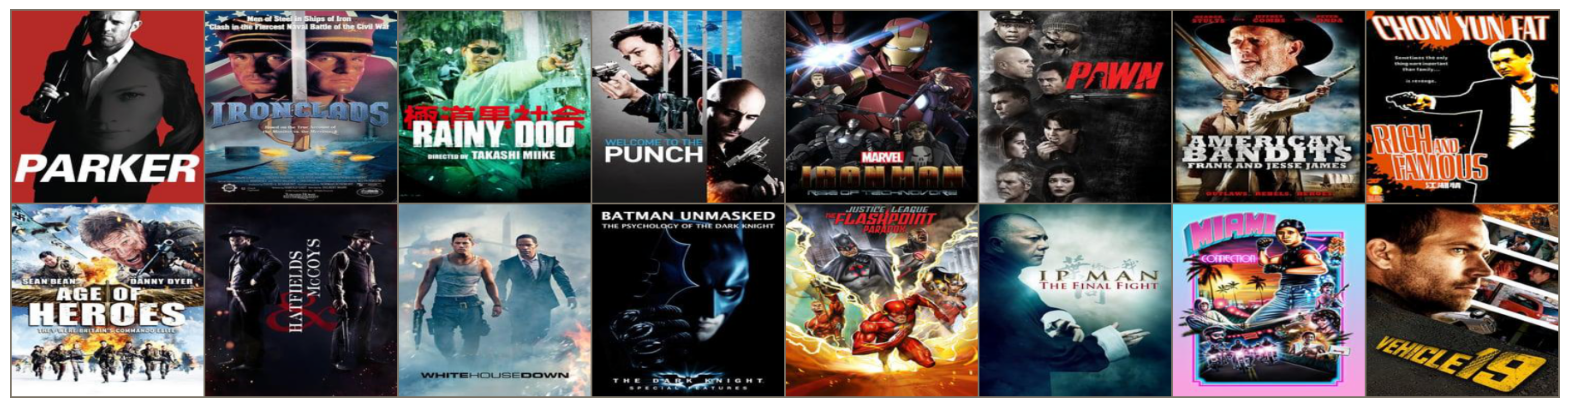

In [19]:
x, paths = next(iter(dataloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Normalisation des données

In [47]:
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                normalize])


train_size = int(0.8 * len(dataset))  # 80% pour l'entraînement
test_size = len(dataset) - train_size  # 20% pour le test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)  
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

#dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

Mise en place du modèle pré-entrainé

Les architectures ResNet sont souvent utilisés pour des problèmes de classification

In [53]:
resnet = models.resnet18(pretrained=True)

# Modifier la dernière couche pour le nombre de genres
num_classes = len(dataset.classes)  # Nombre de genres
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

C:\Users\lisec\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\lisec/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:36<00:00, 1.29MB/s]


In [ ]:
mobilenet = models.mobilenet_v3_small(pretrained=True)

Utilisation d'un modèle séquentiel pour obtenir uniquement les caractéristiques suivies de la couche avgpool de MobileNet, et terminer par une couche Flatten

In [49]:
N_genres = len(dataset.classes)

model = nn.Sequential(
          mobilenet.features,
          mobilenet.avgpool,
          nn.Flatten(),
          nn.Linear(576, N_genres) #rajout d'une couche de classification pour prédire le genre de film
        )#.cuda

In [50]:
x = torch.zeros(100, 3, 224,224)#.cuda
y = model(x)
y.shape

torch.Size([100, 10])

In [22]:
import pandas as pd
from tqdm.notebook import tqdm

features_list = []
paths_list = []

for x, paths in tqdm(dataloader):
    with torch.no_grad():
        embeddings = model(x)
        features_list.extend(embeddings.cpu().numpy())
        paths_list.extend(paths)

df = pd.DataFrame({
    'features': features_list,
    'path': paths_list
})

df.head()

  0%|          | 0/42 [00:00<?, ?it/s]

,features,path
0,"[0.27550504, 0.15441212, -0.054457996, -0.0602...",tensor(0)
1,"[0.8196047, 0.67585355, -0.0755683, -0.1269110...",tensor(0)
2,"[0.40410295, 0.22872525, 0.0740783, 0.83966607...",tensor(0)
3,"[-0.037680436, 0.471763, 0.92925435, 0.4934644...",tensor(0)
4,"[2.4277523, 1.0747422, 0.5087605, 0.932075, 0....",tensor(0)


In [59]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

Entrainement du modèle 

In [ ]:
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(epochs):
    resnet.train()  
    running_loss = 0.0 

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_dataloader):.4f}")


Epoch [1/10], Loss: 1.8561
Epoch [2/10], Loss: 1.4490
Epoch [3/10], Loss: 1.1243
Epoch [4/10], Loss: 0.7499
Epoch [5/10], Loss: 0.4273
Epoch [6/10], Loss: 0.2659


In [57]:
torch.save(resnet.state_dict(), "resnet_genre_classifier.pth")

Evaluation du modèle

In [58]:
resnet.eval() 

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
      
        outputs = resnet(inputs)
        
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

  0%|          | 0/34 [00:00<?, ?it/s]

Accuracy: 9.09%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


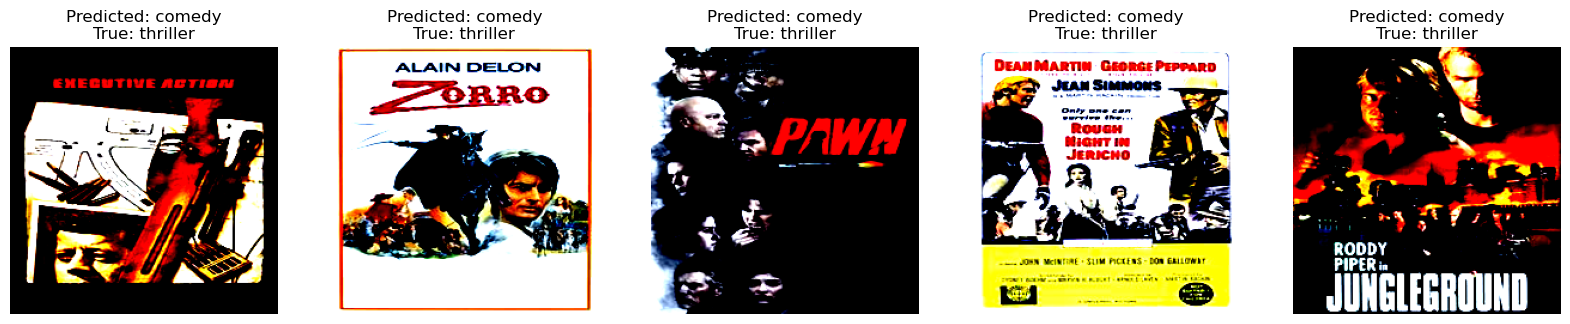

In [44]:
def show_predictions(model, dataloader, num_images=5):
    model.eval()  
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    
    with torch.no_grad():
        for inputs, paths in dataloader:
            inputs = inputs.to(device)  
            outputs = model(inputs)  
            _, preds = torch.max(outputs, 1)  
            
            # Afficher les images et les prédictions faites
            for i in range(num_images):
                ind = np.random.randint(0, inputs.size(0))
               
                if images_shown >= num_images:
                    break
                axes[images_shown].imshow(inputs[ind].cpu().numpy().transpose((1, 2, 0)))  
                axes[images_shown].set_title(f"Predicted: {dataloader.dataset.classes[preds[ind]]}\nTrue: {dataloader.dataset.classes[labels[ind]]}")
                axes[images_shown].axis('off')  
                images_shown += 1


        plt.show()

        
show_predictions(model, dataloader, num_images=5)
